## **Final Project Submission**

Please fill out:
* Student name: Darius Fuller
* Student pace: Part-time
* Scheduled project review date/time: 3/09/2020 
* Instructor name: James Irving
* Blog post URL:https://medium.com/@d_full22/working-with-northwind-66a689a3b0fe

## Setting Up

In [1]:
import scipy.stats as stats
import statsmodels.api as sms
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functions as fn
import sqlite3
import fsds_100719 as fs
import warnings
warnings.filterwarnings('ignore')

fsds_1007219  v0.7.4 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 
> For convenient loading of standard modules use: `>> from fsds_100719.imports import *`



### Combinations

> ***How many ways can we create a subset $k$ out of $n$ objects?***

- Combinations are unordered.

- **The # of combinations equals number of variations, over the number of permutations:**
$$ \large C_{p}^{n}  = \frac{V_{p}^{n}}{P_p} = \frac{n!}{p!(n-p)!} $$


- Also represented as:
$$\displaystyle\binom{n}{k} = \dfrac{P_{k}^{n}}{k!}=\dfrac{ \dfrac{n!}{(n-k)!}}{k!} = \dfrac{n!}{(n-k)!k!}$$



In [2]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = sqlite3.Cursor(conn)

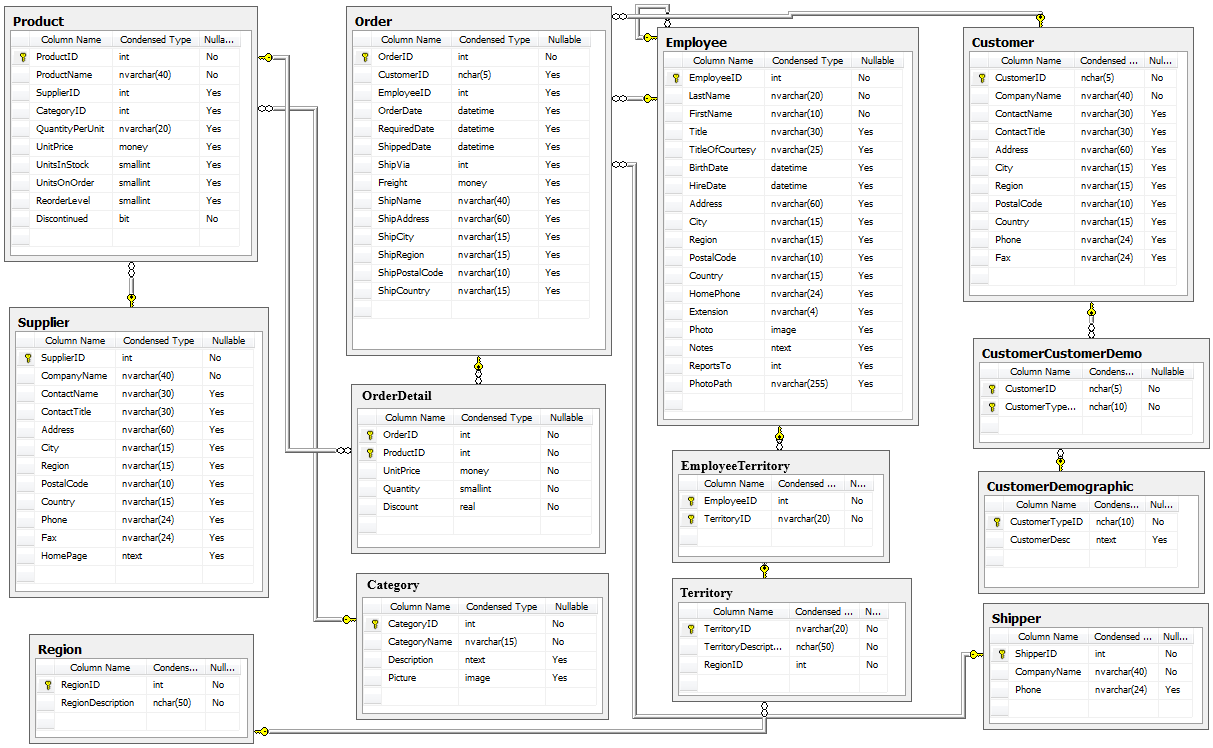

In [3]:
cur.execute('''SELECT name 
               FROM sqlite_master
               WHERE type='table';''')

df_table = pd.DataFrame(cur.fetchall(), columns=['Table'])

df_table # Verifying the images results

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


## Q1: **Does discounting an order have a statistically significant effect on the quantity of a product in that order? If so, at what level(s) of discount?**

- $H_0$: Discounting does not significantly effect the amount of products ordered.
- $H_1$: Discounts do have a significant effect (positive or negative) on the amount of products ordered.

> For this test, I will be using a two-tailed test.

### Initial Query & Feature Engineering

In [4]:
cur.execute('''SELECT *
               FROM OrderDetail o;''')
df1 = pd.DataFrame(cur.fetchall()) 
df1.columns = [i[0] for i in cur.description]
df1.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


> Here I look to create a boolean column to indicated if a column has been discounted or not.

In [5]:
df1['Discounted'] = df1['Discount'] > 0

In [6]:
df1['Discounted'].sum() # How many discounted (True) orders are there? 

838

In [7]:
df1.head() # Quick check

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discounted
0,10248/11,10248,11,14.0,12,0.0,False
1,10248/42,10248,42,9.8,10,0.0,False
2,10248/72,10248,72,34.8,5,0.0,False
3,10249/14,10249,14,18.6,9,0.0,False
4,10249/51,10249,51,42.4,40,0.0,False


### EDA

> Checking to see whether or not there is a visual difference between the two groups: Discounted (True) or Full Price (False)

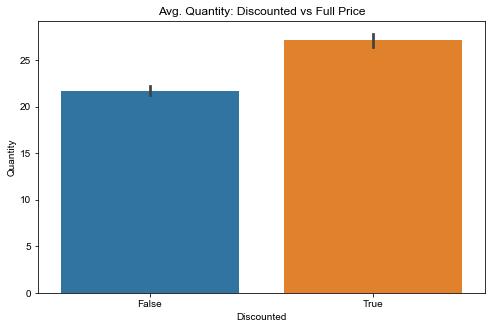

In [8]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=df1, x='Discounted', y='Quantity', ci=68, ax=ax)
sns.set(style='darkgrid')
plt.title('Avg. Quantity: Discounted vs Full Price');

> In order to have a more flexible instance of my target data, I need to move the information from the DataFrame into a python dictionary.

In [9]:
quantVSdisc = {}
for item in df1['Discounted'].unique():
    quantVSdisc[item] = df1.groupby('Discounted').get_group(item)['Quantity']

In [10]:
print(len(quantVSdisc[False]), len(quantVSdisc[True])) 
# Confirming results transferred to dictionary

1317 838


> It is clear, *visually*, that there may be a valid effect on the quantity purchased if the order is discounted. There are two groups of interest and thus I will be checking the assumptions for a **2 Sample T-test**.

### Testing Assumptions (2 Sample T-test)

#### Outliers?

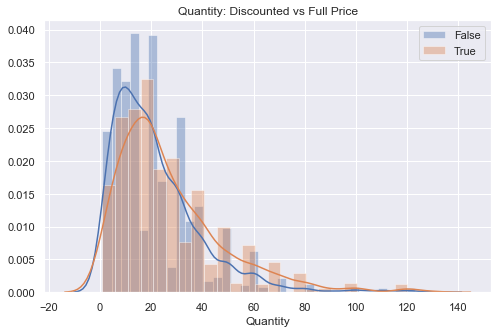

In [11]:
fig, ax = plt.subplots(figsize=(8,5))

for key, val in quantVSdisc.items():
    if key == True:
        lab = 'Discounted'
    else:
        lab = 'Full Price'
        
    sns.distplot(val, label=key, ax=ax)

plt.title('Quantity: Discounted vs Full Price')
ax.legend();

# Visual check for skew

> Although skewed, the tails do not look very thick, will remove some outliers to try for better normality since I have a lot of data still.

In [12]:
for key, val in quantVSdisc.items():
    out_dict = fn.find_outliers_Z(val)
    print(f'There are {out_dict.sum()} {key} Z-outliers.')
    
    out_dict = fn.find_outliers_IQR(val)
    print(f'There are {out_dict.sum()} {key} IQR-outliers.')

There are 20 False Z-outliers.
There are 34 False IQR-outliers.
There are 15 True Z-outliers.
There are 29 True IQR-outliers.


> Checking IQR method for posterity, although I intend to use the Z-score method to remain conservative with removal of data.

In [13]:
for key, val in quantVSdisc.items():
    out_dict = fn.find_outliers_Z(val)
    quantVSdisc[key] = val[~out_dict]
    
# Removing values outside of +/- 3 Z-scores from mean directly from dictionary

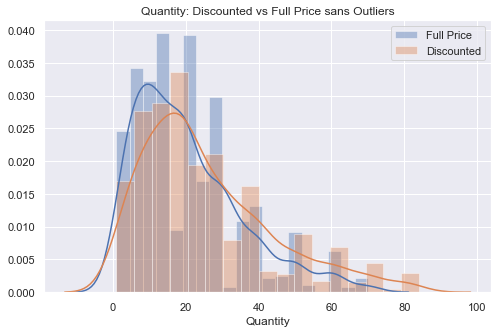

In [14]:
fig, ax = plt.subplots(figsize=(8,5))

for key, val in quantVSdisc.items():
    if key == True:
        lab = 'Discounted'
    else:
        lab = 'Full Price'
        
    sns.distplot(val, label=lab, ax=ax)

plt.title('Quantity: Discounted vs Full Price sans Outliers')
ax.legend();

# 2nd visual check (now without outliers)

> The data looks a lot closer to standard normal. Now I can move forward to test normality.

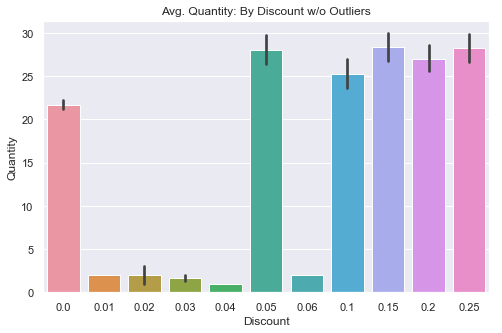

In [15]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=df1, x='Discount', y='Quantity', ci=68, ax=ax)
sns.set(style='darkgrid')
plt.title('Avg. Quantity: By Discount w/o Outliers');

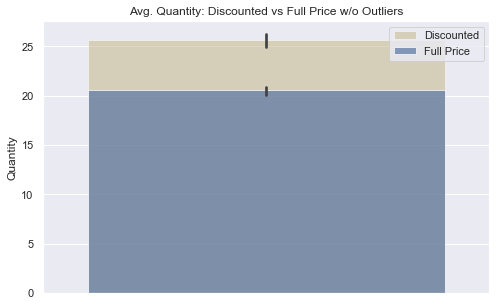

In [16]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=quantVSdisc, y=True, ci=68, ax=ax, alpha=.5, color='y', label='Discounted')
sns.barplot(data=quantVSdisc, y=False, ci=68, ax=ax, alpha=.7, label='Full Price')
sns.set(style='darkgrid')
plt.legend()
plt.title('Avg. Quantity: Discounted vs Full Price w/o Outliers');

> After removing some of the outliers the data has not changed much visually.

#### Normality?

In [17]:
for key, val in quantVSdisc.items():
    stat, p = stats.normaltest(val)
    
    if key == True:
        lab = 'Discounted'
    else:
        lab = 'Full Price'
    
    print(f'{lab} normal test p-value = {round(p,4)}')
    
    sig = 'is NOT' if p < .05 else 'IS'
    
    print(f'The data {sig} normal.')

Full Price normal test p-value = 0.0
The data is NOT normal.
Discounted normal test p-value = 0.0
The data is NOT normal.


In [18]:
print(len(quantVSdisc[False]), len(quantVSdisc[True]))

1297 823


> The data is *not* normal in either sample. This means to move forward I need to have samples larger than 15 each (recommended). Since I have 1,297 Full Price and 823 Discounted I can do so.

#### Equal Variance?

> In order for stats.levene() to properly accept my data, I need to unpack my dictionary into a list.

In [19]:
norm_list = []

for key, val in quantVSdisc.items():
    norm_list.append(val)

In [20]:
stat, p = stats.levene(*norm_list)

print(f'Levene test p-value = {round(p,4)}')

sig = 'does NOT' if p < .05 else 'DOES'

print(f'The data {sig} have equal variance.')

Levene test p-value = 0.0
The data does NOT have equal variance.


> Since the Levene test was failed, I must use the Welch's T-test function with the 'equal_var' parameter set to 'False' in order to determine whether or not I am dealing with two samples from different populations and test my hypothesis.

### Hypothesis Test

In [21]:
stat, p = stats.ttest_ind(*norm_list, equal_var=False)

print(f"Welch's T-test p-value = {round(p,4)}")

sig = 'IS' if p < .05 else 'is NOT'

print(f'The data {sig} from different populations.')

Welch's T-test p-value = 0.0
The data IS from different populations.


> The data does *NOT* have equal variance but *IS* from different populations. Given the information above, I can move forward with **Rejecting the Null Hypothesis ($H_0$)**.

### Post-Hoc Calculations

In [22]:
eff_size = fn.Cohen_d(quantVSdisc[True], quantVSdisc[False])

eff_size

0.32001140965727837

> Given the standard interpretation of Cohen's D, our value falls between the 'small effect' category (0.2) and 'medium effect' category (0.5). Therefore we can say, although relatively small, discounts **do** have an effect on the quantity purchased.

In [23]:
model = pairwise_tukeyhsd(df1['Quantity'], df1['Discount'])
model.summary()

group1,group2,meandiff,lower,upper,reject
0.0,0.01,-19.7153,-80.3306,40.9001,False
0.0,0.02,-19.7153,-62.593,23.1625,False
0.0,0.03,-20.0486,-55.0714,14.9742,False
0.0,0.04,-20.7153,-81.3306,39.9001,False
0.0,0.05,6.2955,1.5381,11.053,True
0.0,0.06,-19.7153,-80.3306,40.9001,False
0.0,0.1,3.5217,-1.3783,8.4217,False
0.0,0.15,6.6669,1.551,11.7828,True
0.0,0.2,5.3096,0.2508,10.3684,True
0.0,0.25,6.525,1.3647,11.6852,True


In [24]:
df_tukey1 = fn.prep_data_for_tukeys(quantVSdisc)
df_tukey1.head()

,data,group
0,12.0,False
1,10.0,False
2,5.0,False
3,9.0,False
4,40.0,False


In [25]:
model_2 = pairwise_tukeyhsd(df_tukey1['data'], df_tukey1['group'])
model_2.summary()

#quick check without outliers

group1,group2,meandiff,lower,upper,reject
False,True,5.1193,3.7212,6.5174,True


> Given an alpha level of 0.05, I can **reject** the null hypothesis for the following discount levels:
* 5%
* 15%
* 20%
* 25%

### Q1 Summary

> After testing my hypothesis regarding quantity on discounted orders, I can say to stakeholders that discounting does in fact have a *significant* effect on the quantity of any given order. 

> Additionally, I can say that the discount levels (in descending order) of 15%, 25%, 5%, 20% have the most significant effect on the avg. quantity of a given order. 

**Recommendations:** Given this information, I would suggest that they have no reason to give discounts larger than 5%, as it effects the quantity purchased just the same as any of the higher options.

## Q2: Does discount amount have a statistically significant effect on the total amount spent in an order? If so, at what level(s) of discount?

- $H_0$: Discount amount does not significantly effect the total amount of money spent.
- $H_1$: Discounts do have a significant effect (positive or negative) on the total amount of money spent.

> For this test, I will be using a two-tailed test.

### Initial Query & Feature Engineering

> I will do a very similar setup to the previous hypothesis for the quantity exploration.

In [26]:
cur.execute('''SELECT *
               FROM OrderDetail o;''')
df2 = pd.DataFrame(cur.fetchall()) 
df2.columns = [i[0] for i in cur.description]
df2.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [27]:
df2['Discounted'] = df2['Discount'] > 0
# Creating boolean column for discount or full price

In [28]:
df2['TotalSpent'] = (df2['UnitPrice'] * (1-df2['Discount'])) * df2['Quantity']
# Creating a numerical column for total price spent per order (including discount)

In [29]:
df2.head() # Quick check

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discounted,TotalSpent
0,10248/11,10248,11,14.0,12,0.0,False,168.0
1,10248/42,10248,42,9.8,10,0.0,False,98.0
2,10248/72,10248,72,34.8,5,0.0,False,174.0
3,10249/14,10249,14,18.6,9,0.0,False,167.4
4,10249/51,10249,51,42.4,40,0.0,False,1696.0


### EDA

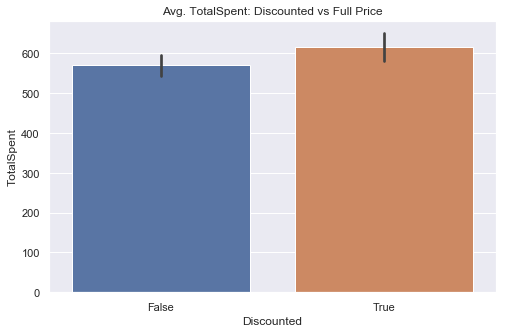

In [30]:
# Visual check

fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=df2, x='Discounted', y='TotalSpent', ci=68, ax=ax)
sns.set(style='darkgrid')
plt.title('Avg. TotalSpent: Discounted vs Full Price');

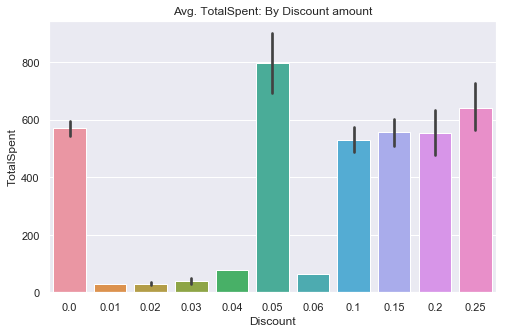

In [31]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=df2, x='Discount', y='TotalSpent', ci=68, ax=ax)
sns.set(style='darkgrid')
plt.title('Avg. TotalSpent: By Discount amount');

> Actually splitting the data by discount amount seems to indicate more of difference than grouping them by T/F values.

> Converting to a dictionary for flexibility (as before)

Replace discounted with discount before doing ANOVA and proceed normally

In [32]:
totspentVSdisc = {}
for item in df2['Discount'].unique():
    totspentVSdisc[item] = df2.groupby('Discount').get_group(item)['TotalSpent']

In [33]:
for key, val in totspentVSdisc.items():
    print(f'{key}: {len(totspentVSdisc[key])}')
# Verifying results

0.0: 1317
0.15: 157
0.05: 185
0.2: 161
0.25: 154
0.1: 173
0.02: 2
0.03: 3
0.04: 1
0.06: 1
0.01: 1


> There is, *visually*, a small difference in the average total spent per order if grouped in a binary fashion. Not too hopeful of its significance, but it is still worth investigation. Splitting into groups appears to show more of a significance between discount levels. It does appear some of the groups do not have enough data points to be used. I need to use an **ANOVA Test** in order to verify my visuals.

### Testing Assumptions (One-Way ANOVA)

#### Outliers?

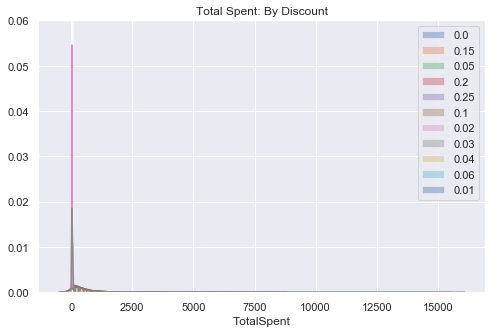

In [34]:
fig, ax = plt.subplots(figsize=(8,5))

for key, val in totspentVSdisc.items():
    if key == True:
        lab = 'Discount'
    else:
        lab = 'Full Price'
        
    sns.distplot(val, label=key, ax=ax)

plt.ylim(top=0.06)
plt.title('Total Spent: By Discount')
ax.legend();

# Visual check for skew

> This is *highly* skewed to the right and very thin. There are *a lot* of datapoints clustered close to 0. Removing the outliers will be helpful.

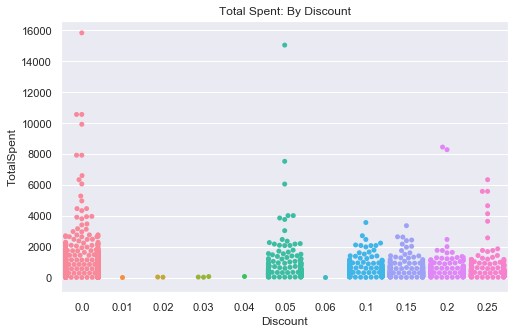

In [35]:
fig, ax = plt.subplots(figsize=(8,5))

sns.swarmplot(data=df2, x='Discount', y='TotalSpent', ax=ax)

plt.title('Total Spent: By Discount');

> Using the swarmpplot shows a lot more as to which are the most offered discounts (or not) and the amount of data within each group.

In [36]:
for key, val in totspentVSdisc.items():
    out_dict = fn.find_outliers_Z(val)
    print(f'There are {out_dict.sum()} {key} Z-outliers.')
    
    out_dict = fn.find_outliers_IQR(val)
    print(f'There are {out_dict.sum()} {key} IQR-outliers.')

There are 19 0.0 Z-outliers.
There are 101 0.0 IQR-outliers.
There are 5 0.15 Z-outliers.
There are 11 0.15 IQR-outliers.
There are 3 0.05 Z-outliers.
There are 17 0.05 IQR-outliers.
There are 2 0.2 Z-outliers.
There are 9 0.2 IQR-outliers.
There are 6 0.25 Z-outliers.
There are 11 0.25 IQR-outliers.
There are 3 0.1 Z-outliers.
There are 13 0.1 IQR-outliers.
There are 0 0.02 Z-outliers.
There are 0 0.02 IQR-outliers.
There are 0 0.03 Z-outliers.
There are 0 0.03 IQR-outliers.
There are 0 0.04 Z-outliers.
There are 0 0.04 IQR-outliers.
There are 0 0.06 Z-outliers.
There are 0 0.06 IQR-outliers.
There are 0 0.01 Z-outliers.
There are 0 0.01 IQR-outliers.


> Despite there being a very long tail, I will for consistency stick with Z-scores in order to remain conservative.

In [37]:
for key, val in totspentVSdisc.items():
    out_dict = fn.find_outliers_Z(val)
    totspentVSdisc[key] = val[~out_dict]
    
# Removing values outside of +/- 3 Z-scores from mean directly from dictionary

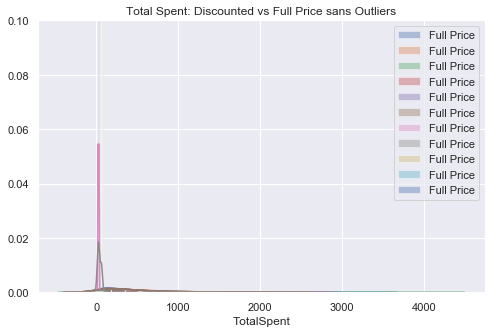

In [38]:
fig, ax = plt.subplots(figsize=(8,5))

for key, val in totspentVSdisc.items():
    if key == True:
        lab = 'Discount'
    else:
        lab = 'Full Price'
        
    sns.distplot(val, label=lab, ax=ax)

plt.ylim(top=0.1)
plt.title('Total Spent: Discounted vs Full Price sans Outliers')
ax.legend();

# 2nd visual check (now without outliers)

In [39]:
df2_no_out = fn.diction_to_df(totspentVSdisc, ['Discount', 'TotalSpent'])

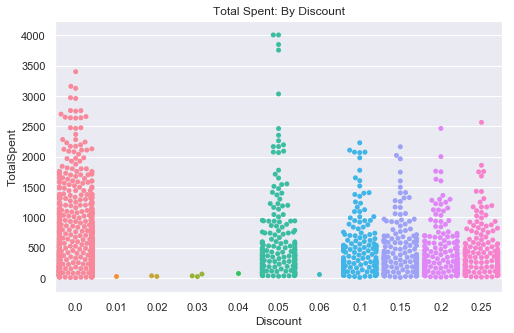

In [40]:
fig, ax = plt.subplots(figsize=(8,5))

sns.swarmplot(data=df2_no_out, x='Discount', y='TotalSpent', ax=ax)

plt.title('Total Spent: By Discount');

> Although, if compared to the standard normal distribution, the data is still pretty skewed to the right. After removing outliers, the spread seems to be more even. I will move forward with testing assumptions.

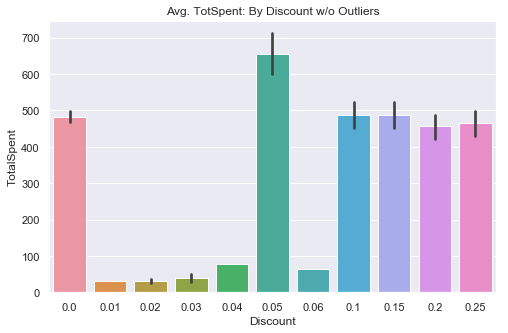

In [41]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=df2_no_out, x='Discount', y='TotalSpent', ci=68, ax=ax)
sns.set(style='darkgrid')
plt.title('Avg. TotSpent: By Discount w/o Outliers');

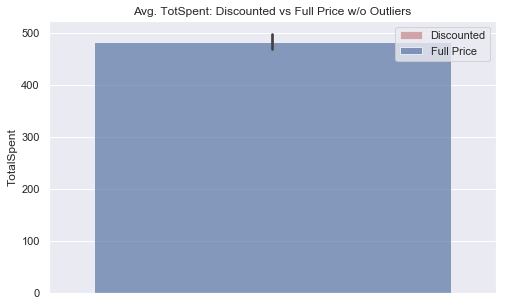

In [42]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=totspentVSdisc, y=True, ci=68, ax=ax, alpha=.5, color='r', label='Discounted')
sns.barplot(data=totspentVSdisc, y=False, ci=68, ax=ax, alpha=.7, label='Full Price')
sns.set(style='darkgrid')
plt.legend()
plt.title('Avg. TotSpent: Discounted vs Full Price w/o Outliers');

> Given the error bars on this bar plot, I would not be surprised to find there is not a significance between the two groups.

#### Normality?

> Before I can test for normality, I need to remove those discount levels at which I do not have enough data to test for normality. These levels are 1% - 6% (except 5%).

In [43]:
keys2drop = [0.02, 0.03, 0.04, 0.06, 0.01]

for item in keys2drop:
    del totspentVSdisc[item]
    
totspentVSdisc.keys()

dict_keys([0.0, 0.15, 0.05, 0.2, 0.25, 0.1])

In [44]:
for key, val in sorted(totspentVSdisc.items()):
    stat, p = stats.normaltest(val)
    
    print(f'{key} normal test p-value = {round(p,4)}')
    
    sig = 'is NOT' if p < .05 else 'IS'
    
    print(f'The data {sig} normal.')

0.0 normal test p-value = 0.0
The data is NOT normal.
0.05 normal test p-value = 0.0
The data is NOT normal.
0.1 normal test p-value = 0.0
The data is NOT normal.
0.15 normal test p-value = 0.0
The data is NOT normal.
0.2 normal test p-value = 0.0
The data is NOT normal.
0.25 normal test p-value = 0.0
The data is NOT normal.


> No surprises here, this data is *not* normal.

In [45]:
for key, val in totspentVSdisc.items():
    print(f'{key}: {len(totspentVSdisc[key])}')

0.0: 1298
0.15: 152
0.05: 182
0.2: 159
0.25: 148
0.1: 170


> Luckily, after removing outliers and those groups without enough datapoints, I am left with 6 groups to work with in my testing. 

#### Equal Variance?

In [46]:
# Same as before

norm_list2 = []

for key, val in totspentVSdisc.items():
    norm_list2.append(val)

In [47]:
stat, p = stats.levene(*norm_list2)

print(f'Levene test p-value = {round(p,4)}')

sig = 'does NOT' if p < .05 else 'DOES'

print(f'The data {sig} have equal variance.')

Levene test p-value = 0.01
The data does NOT have equal variance.


> We were really close to getting equal variance with a p-value within 0.006 of our alpha level (0.05). However, I also have enough in each group to proceed without having equal variance, so this will not weigh too much on my results.

### Hypothesis Test

In [48]:
stat, p = stats.f_oneway(*norm_list2)

print(f"One-Way ANOVA p-value = {round(p,4)}")

sig = 'IS' if p < .05 else 'is NOT'

print(f'The data {sig} from different populations.')

One-Way ANOVA p-value = 0.0019
The data IS from different populations.


> At this point, I have sufficient evidence to **reject the null hypothesis**.

### Post-Hoc Calculations

> After rejecting the null, I want to investigate if at a given level, a discount *does* have a significant effect upon the total amount spent.

In [49]:
model2 = pairwise_tukeyhsd(df2['TotalSpent'], df2['Discount'])
model2.summary()

group1,group2,meandiff,lower,upper,reject
0.0,0.01,-540.3065,-3662.2549,2581.6418,False
0.0,0.02,-540.1165,-2748.5047,1668.2716,False
0.0,0.03,-529.703,-2333.5278,1274.1217,False
0.0,0.04,-492.2465,-3614.1949,2629.7018,False
0.0,0.05,227.9252,-17.1036,472.954,False
0.0,0.06,-506.0865,-3628.0349,2615.8618,False
0.0,0.1,-41.1098,-293.48,211.2604,False
0.0,0.15,-12.6424,-276.1341,250.8493,False
0.0,0.2,-16.0866,-276.6374,244.4641,False
0.0,0.25,72.4517,-193.3232,338.2266,False


In [50]:
df_tukey2 = fn.prep_data_for_tukeys(totspentVSdisc)
df_tukey2.head()

,data,group
0,168.0,0.0
1,98.0,0.0
2,174.0,0.0
3,167.4,0.0
4,1696.0,0.0


In [51]:
model2_2 = pairwise_tukeyhsd(df_tukey2['data'], df_tukey2['group'])
model2_2.summary()

group1,group2,meandiff,lower,upper,reject
0.0,0.05,171.3373,53.6087,289.0659,True
0.0,0.1,4.16,-117.158,125.478,False
0.0,0.15,4.6481,-122.8633,132.1595,False
0.0,0.2,-26.8771,-151.8506,98.0964,False
0.0,0.25,-16.0809,-145.1256,112.9638,False
0.05,0.1,-167.1773,-325.8256,-8.529,True
0.05,0.15,-166.6892,-330.1223,-3.2562,True
0.05,0.2,-198.2144,-359.6752,-36.7536,True
0.05,0.25,-187.4182,-352.0503,-22.7861,True
0.1,0.15,0.4881,-165.5493,166.5254,False


> After checking on the data without outliers, I was able to indicate significant relationships between:
* (0, 0.05)
* (0.05, 0.10)
* (0.05, 0.20)

### Q2 Summary

> After testing my hypothesis regarding the total amount spent on discounted orders, I can say to stakeholders that discounting **does** have a statisitcally significant effect on the total amount spent on any given order. 

> Additionally, I can say that the discount level that has the most significance between groups is the 5% discount group. This level was significant unless compared to 15% and 25% (which neither proved to be significant *anywhere*).

**Recommendations:** Now, with the knowledge that discounting has a significant effect on the quantity purchased *and* the total amount spent, I would recommend that they either: 
* Stop offering higher (>5%) discounts in general

**OR**

* Do not give more than 15%, as my results show that this is the next level at which there is not *significant* difference.

## Q3: Does the region in which the products are sold have a significant effect on the quantity of a product in an order? If so, which region buys the most?

- $H_0$: RegionID does not significantly effect the amount of products ordered.
- $H_1$: RegionID does have a significant effect (positive or negative) on the amount of products ordered.

> For this test, I will be using a two-tailed test.

### Initial Query & Feature Engineering

In [52]:
cur.execute('''SELECT DISTINCT(o.OrderId), o.Quantity, r.Id, r.RegionDescription
               FROM OrderDetail o
               JOIN 'Order' ord
               ON o.OrderId = ord.Id
               JOIN Employee e
               ON ord.EmployeeId = e.Id
               JOIN EmployeeTerritory et
               USING(EmployeeId)
               JOIN Territory t
               ON et.TerritoryId = t.Id
               JOIN Region r
               ON r.Id = t.RegionId;''') 
df3 = pd.DataFrame(cur.fetchall()) 
df3.columns = [i[0] for i in cur.description]
df3.head()

,OrderId,Quantity,Id,RegionDescription
0,10248,12,1,Eastern
1,10248,10,1,Eastern
2,10248,5,1,Eastern
3,10249,9,2,Western
4,10249,40,2,Western


> I ran into a duplication error due to (likely) the Order Id and Employee Id's being one-to-many during the joining process; coercing the OrderIds to be *distinct* should solve this.

### EDA

> **Region Descriptors**
1. 'Eastern'
2. 'Western'
3. 'Northern'
4. 'Southern'

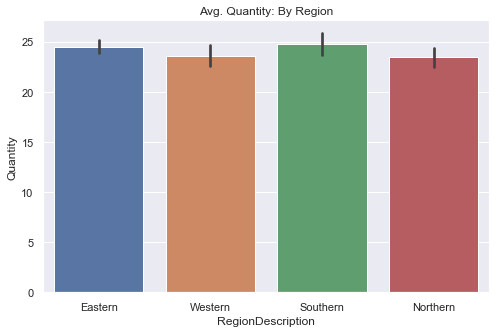

In [53]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=df3, x='RegionDescription', y='Quantity', ci=68, ax=ax)

plt.title('Avg. Quantity: By Region');

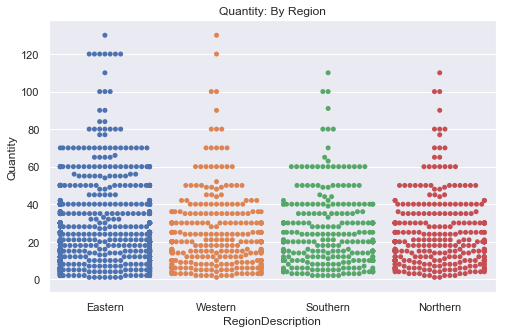

In [54]:
# Quick check of differences via swarmplot

fig, ax = plt.subplots(figsize=(8,5))

sns.swarmplot(data=df3, x='RegionDescription', y='Quantity', ax=ax)

plt.title('Quantity: By Region');

In [55]:
quantVSreg = {}
for item in df3['RegionDescription'].unique():
    quantVSreg[item] = df3.groupby('RegionDescription').get_group(item)['Quantity']

In [56]:
for item in df3['RegionDescription'].unique():
    print(f'Number of instances in {item}: {len(quantVSreg[item])}')

Number of instances in Eastern: 1022
Number of instances in Western: 325
Number of instances in Southern: 302
Number of instances in Northern: 349


> Visually there is not a large difference between regions, however my goal is simply to find out whether or not an effect exists. It is clear that the Eastern region does make up almost 50% of the orders they received during the period of time this data represents. Due to our data being more than two groups, I will need to proceed with a **One-Way ANOVA** test.

### Testing Assumptions (One-Way ANOVA)

#### Outliers?

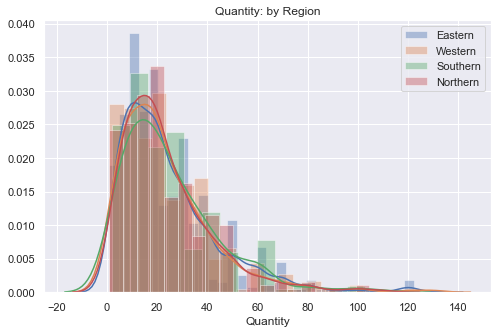

In [57]:
fig, ax = plt.subplots(figsize=(8,5))

for key, val in quantVSreg.items():       
    sns.distplot(val, label=key, ax=ax)

plt.title('Quantity: by Region')
ax.legend();

# Visual check for skew

> All of the groups appear to have a similar level of skew and weight in the right tail. There is one item for the Eastern group that hangs pretty far into the tail, I am interested to see whether or not it will fall off after outliers are removed.

In [58]:
for key, val in quantVSreg.items():
    out_dict = fn.find_outliers_Z(val)
    print(f'There are {out_dict.sum()} {key} Z-outliers.')
    
    #out_dict = fn.find_outliers_IQR(val)
    #print(f'There are {out_dict.sum()} {key} IQR-outliers.')

There are 14 Eastern Z-outliers.
There are 5 Western Z-outliers.
There are 4 Southern Z-outliers.
There are 8 Northern Z-outliers.


In [59]:
# Removing outliers per the Z-score method

for key, val in quantVSreg.items():
    out_dict = fn.find_outliers_Z(val)
    quantVSreg[key] = val[~out_dict]

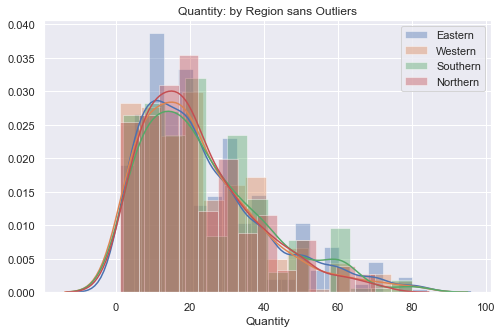

In [60]:
fig, ax = plt.subplots(figsize=(8,5))

for key, val in quantVSreg.items():
    sns.distplot(val, label=key, ax=ax)

plt.title('Quantity: by Region sans Outliers')
ax.legend();

# 2nd visual check (now without outliers)

> My function removed a large bit of the tails, and visually I can see that the Northern/Eastern groups do not skew out as far as the other two groups.

In [61]:
tst3 = []

for key, val in quantVSreg.items():
    for item in val:
        tst3.append((key, item))

In [62]:
q3_fin = pd.DataFrame.from_records(data=tst3, columns=['Region', 'Quantity'])
q3_fin.head()

,Region,Quantity
0,Eastern,12
1,Eastern,10
2,Eastern,5
3,Eastern,10
4,Eastern,35


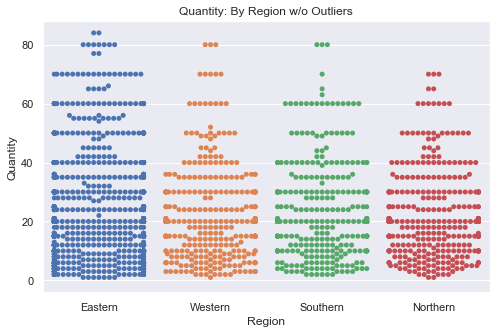

In [63]:
fig, ax = plt.subplots(figsize=(8,5))

sns.swarmplot(data=q3_fin, x='Region', y='Quantity', ax=ax)

plt.title('Quantity: By Region w/o Outliers');

> Once outliers have been removed, it appears that the differences shown in my prior plot have been lessened.

#### Normality?

In [64]:
for key, val in quantVSreg.items():
    stat, p = stats.normaltest(val)
        
    print(f'{key} normal test p-value = {round(p,4)}')
    
    sig = 'is NOT' if p < .05 else 'IS'
    
    print(f'The data {sig} normal.')

Eastern normal test p-value = 0.0
The data is NOT normal.
Western normal test p-value = 0.0
The data is NOT normal.
Southern normal test p-value = 0.0
The data is NOT normal.
Northern normal test p-value = 0.0
The data is NOT normal.


In [65]:
for item in df3['RegionDescription'].unique():
    print(f'Number of instances in {item}: {len(quantVSreg[item])}')

Number of instances in Eastern: 1008
Number of instances in Western: 320
Number of instances in Southern: 298
Number of instances in Northern: 341


> Not a single group is considered normal. However, due to the groups all having more than 15 instances (by far), I am able to ignore this assumption and test for equal variance.

#### Equal Variance?

In [66]:
norm_list3 = []

for key, val in quantVSreg.items():
    norm_list3.append(val)

In [67]:
stat, p = stats.levene(*norm_list3)

print(f'Levene test p-value = {round(p,4)}')

sig = 'does NOT' if p < .05 else 'DOES'

print(f'The data {sig} have equal variance.')

Levene test p-value = 0.11
The data DOES have equal variance.


> Since the data passed Levene's test, I am able to safely move forward with a standard One-Way ANOVA in order to see if my samples are from different populations and test my hypothesis.

### Hypothesis Test

In [68]:
stat, p = stats.f_oneway(*norm_list3)

print(f"One-Way ANOVA p-value = {round(p,4)}")

sig = 'IS' if p < .05 else 'is NOT'

print(f'The data {sig} from different populations.')

One-Way ANOVA p-value = 0.3789
The data is NOT from different populations.


> The data does *NOT* have a p-value low enought to say confidently that it is from different populations. Given the information above, I have **failed to reject the Null Hypothesis ($H_0$)**.

### Post-Hoc Calculations

> Although I have failed to reject the null, (as with Q2) I want to investigate if inter-regionally, there *is* have a significant effect upon the average quantity ordered.

In [69]:
model3 = pairwise_tukeyhsd(df3['Quantity'], df3['RegionDescription'])
model3.summary()

group1,group2,meandiff,lower,upper,reject
Eastern,Northern,-1.0508,-4.1218,2.0202,False
Eastern,Southern,0.2852,-2.959,3.5295,False
Eastern,Western,-0.8925,-4.0468,2.2619,False
Northern,Southern,1.336,-2.5569,5.2289,False
Northern,Western,0.1583,-3.66,3.9766,False
Southern,Western,-1.1777,-5.1367,2.7813,False


In [70]:
df_tukey3 = fn.prep_data_for_tukeys(quantVSreg)
df_tukey3.head()

,data,group
0,12.0,Eastern
1,10.0,Eastern
2,5.0,Eastern
5,10.0,Eastern
6,35.0,Eastern


In [71]:
model3_2 = pairwise_tukeyhsd(df_tukey3['data'], df_tukey3['group'])
model3_2.summary()

group1,group2,meandiff,lower,upper,reject
Eastern,Northern,-1.3961,-4.0506,1.2584,False
Eastern,Southern,0.4796,-2.3143,3.2736,False
Eastern,Western,-1.0038,-3.7226,1.715,False
Northern,Southern,1.8757,-1.4844,5.2358,False
Northern,Western,0.3923,-2.9055,3.6902,False
Southern,Western,-1.4834,-4.8945,1.9277,False


### Q3 Summary

> After testing my hypothesis regarding the average quantity ordered per region, I can say to stakeholders that there is **not**, *with 95% confidence*, an effect on the average quantity purchased in a given order. 

> Additionally, I can say that between individual regions, there is no evidence to suggest a significant difference in the average quantity purchased in a given order. 

**Recommendations:** Knowing that no specific region out purchases another, I would recommend that this company consolidate their shipping costs as much as possible. Looking into an option that will provide them the widest reach for the least amount of money will prove useful.

## Q4: Does whether the company keeps an item 'in stock' or not have any effect on the total spent on those products? If so, is there an optimal level to reorder?

- $H_0$: The level at which Northwind re-orders products has no effect on the total amount spent on orders including those items.
- $H_1$: Whether or not Northwind waits until they are out of stock to reorder has an effect on the total amount spent on orders with those items.

> For this test, I will be using a two-tailed test.

### Initial Query & Feature Engineering

In [72]:
cur.execute('''SELECT ord.ProductId, ord.Quantity, ord.UnitPrice, 
               ord.Discount, p.ReorderLevel, p.CategoryId, 
               ((ord.Quantity * ord.UnitPrice)*(1 - ord.Discount)) 
               AS TotalSpent
               FROM OrderDetail ord
               JOIN Product p
               ON ord.ProductId = p.Id;''')
df4 = pd.DataFrame(cur.fetchall()) 
df4.columns = [i[0] for i in cur.description]
df4.head()

,ProductId,Quantity,UnitPrice,Discount,ReorderLevel,CategoryId,TotalSpent
0,11,12,14.0,0.0,30,4,168.0
1,42,10,9.8,0.0,0,5,98.0
2,72,5,34.8,0.0,0,4,174.0
3,14,9,18.6,0.0,0,7,167.4
4,51,40,42.4,0.0,10,7,1696.0


In [73]:
df4.ReorderLevel.value_counts() # Quick check of samples 

0     718
15    273
25    256
10    242
30    235
20    235
5     196
Name: ReorderLevel, dtype: int64

In [74]:
df4.CategoryId.value_counts() # Spread check among categories (for later)

1    404
4    366
3    334
8    330
2    216
5    196
6    173
7    136
Name: CategoryId, dtype: int64

### EDA

> **Reorder Levels**
* 0 - 30 at five unit intervals (0, 5, 10,...30) 

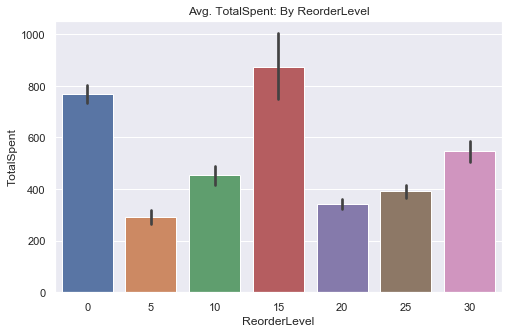

In [75]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=df4, x='ReorderLevel', y='TotalSpent', ci=68, ax=ax)

plt.title('Avg. TotalSpent: By ReorderLevel');

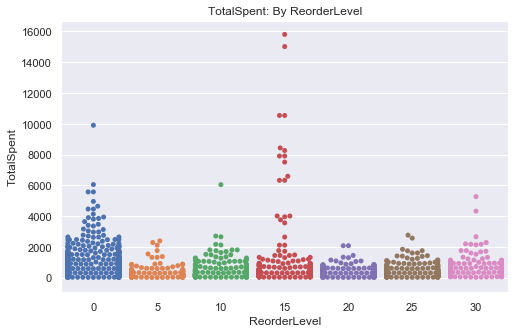

In [76]:
# Quick check of differences via swarmplot (like above)

fig, ax = plt.subplots(figsize=(8,5))

sns.swarmplot(data=df4, x='ReorderLevel', y='TotalSpent', ax=ax)

plt.title('TotalSpent: By ReorderLevel');

In [77]:
totspentVSreord = {}
for item in df4['ReorderLevel'].unique():
    totspentVSreord[item] = df4.groupby('ReorderLevel').get_group(item)['TotalSpent']

In [78]:
# Quick check for correct data transfer

for item in sorted(df4['ReorderLevel'].unique()):
    print(f'Number of instances in {item}: {len(totspentVSreord[item])}')
    
# We're good!

Number of instances in 0: 718
Number of instances in 5: 196
Number of instances in 10: 242
Number of instances in 15: 273
Number of instances in 20: 235
Number of instances in 25: 256
Number of instances in 30: 235


> Visually, I can see that those at a 0 and 15 reorder level tend to stick out with the bar chart. The swarm chart demonstrates why the error bar is so large on the bar chart, the 15 unit reorder level seems to have a wide range of values. I will need to use the **One-Way ANOVA** test since I will be comparing multiple sample populations.

### Testing Assumptions (One-Way ANOVA)

#### Outliers?

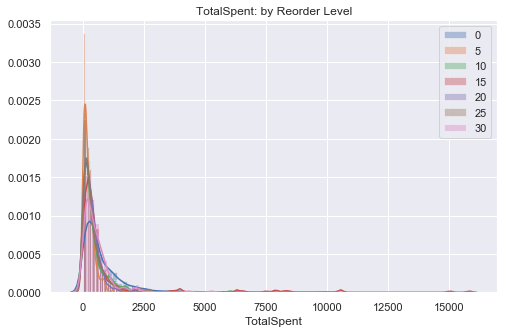

In [79]:
fig, ax = plt.subplots(figsize=(8,5))

for key, val in sorted(totspentVSreord.items()):       
    sns.distplot(val, label=key, ax=ax)

plt.title('TotalSpent: by Reorder Level')
ax.legend();

# Visual check for skew

> The extreme values in one or more of the reorder levels are skewing the distribution strongly. It seems best to remove them to ensure I get closer in the normality test.

In [80]:
for key, val in sorted(totspentVSreord.items()):
    out_dict = fn.find_outliers_Z(val)
    print(f'There are {out_dict.sum()} {key} Z-outliers.')
    
    #out_dict = fn.find_outliers_IQR(val)
    #print(f'There are {out_dict.sum()} {key} IQR-outliers.')
    
    #due to the number of categories, no need to check IQR

There are 15 0 Z-outliers.
There are 5 5 Z-outliers.
There are 3 10 Z-outliers.
There are 9 15 Z-outliers.
There are 5 20 Z-outliers.
There are 5 25 Z-outliers.
There are 3 30 Z-outliers.


> Surprisingly, the 0 level has the most values outside of the +/- 3 z-score threshold.

In [81]:
# Removing outliers per the Z-score method

for key, val in totspentVSreord.items():
    out_dict = fn.find_outliers_Z(val)
    totspentVSreord[key] = val[~out_dict]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


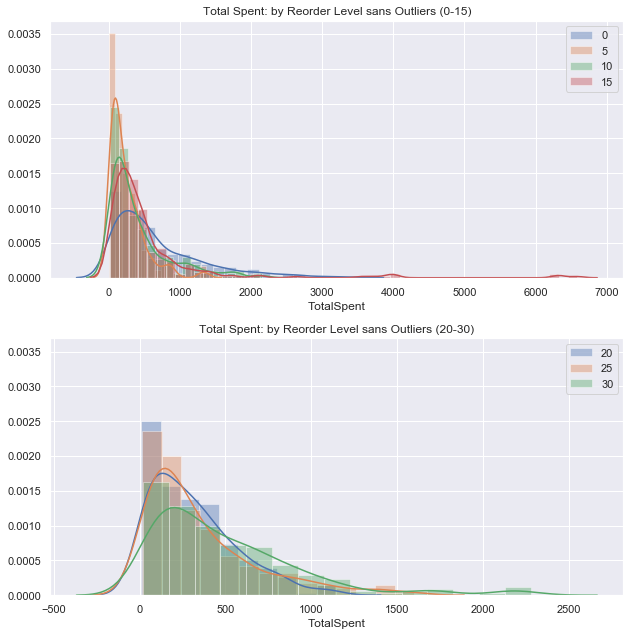

In [82]:
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharey=ax1)

helper = [0, 5, 10, 15]

for key, val in sorted(totspentVSreord.items()):
    if key in helper:
        sns.distplot(val, label=key, ax=ax1).set_title('Total Spent: by Reorder Level sans Outliers (0-15)')
        #plt.legend()
    else:
        sns.distplot(val, label=key, ax=ax2).set_title('Total Spent: by Reorder Level sans Outliers (20-30)')
        #plt.legend()
        
    ax1.legend()
    ax2.legend();
        
plt.tight_layout()


# 2nd visual check (now without outliers)

> Visually it appears that there are some similarities between the groups I selected arbitrarily by numeric value. For the unit level of 5, there is a high amount that spikes around zero TotalSpent, while there is a long tail created by 15. 

> In the second plot, the categories reflect a similar relationship. Two of the categories have a large grouping around zero TotalSpent while the 30 reorder level creates a tail.

In [83]:
tst4 = []

for key, val in totspentVSreord.items():
    for item in val:
        tst4.append((key, item))

In [84]:
q4_fin = pd.DataFrame.from_records(data=tst4, columns=['ReorderLevel', 'TotSpent'])
q4_fin.head()

,ReorderLevel,TotSpent
0,30,168.0
1,30,877.5
2,30,189.0
3,30,60.8
4,30,240.0


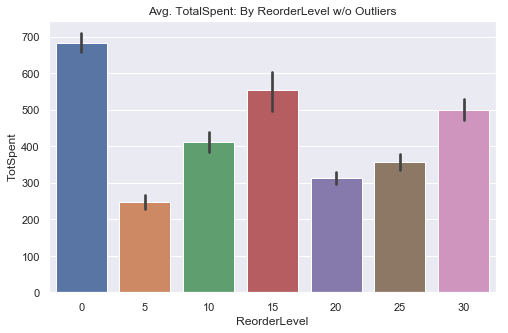

In [85]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=q4_fin, x='ReorderLevel', y='TotSpent', ci=68, ax=ax)

plt.title('Avg. TotalSpent: By ReorderLevel w/o Outliers');

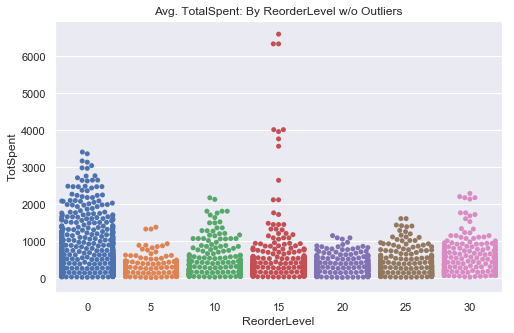

In [86]:
fig, ax = plt.subplots(figsize=(8,5))

sns.swarmplot(data=q4_fin, x='ReorderLevel', y='TotSpent', ax=ax)

plt.title('Avg. TotalSpent: By ReorderLevel w/o Outliers');

> After removing outliers, it appears that we may have some significance among these reorder levels.

#### Normality?

In [87]:
for key, val in sorted(totspentVSreord.items()):
    stat, p = stats.normaltest(val)
        
    print(f'{key} normal test p-value = {round(p,4)}')
    
    sig = 'is NOT' if p < .05 else 'IS'
    
    print(f'The data {sig} normal.')

0 normal test p-value = 0.0
The data is NOT normal.
5 normal test p-value = 0.0
The data is NOT normal.
10 normal test p-value = 0.0
The data is NOT normal.
15 normal test p-value = 0.0
The data is NOT normal.
20 normal test p-value = 0.0
The data is NOT normal.
25 normal test p-value = 0.0
The data is NOT normal.
30 normal test p-value = 0.0
The data is NOT normal.


> My visual observations were confirmed by stats.normaltest(). The data does not appear to be very close to the standard normal, but with the amount of observations in each group we can move forward here regardless of the failures.

In [88]:
# Quick check for sample sizes

for item in sorted(df4['ReorderLevel'].unique()):
    print(f'Number of instances in {item}: {len(totspentVSreord[item])}')

Number of instances in 0: 703
Number of instances in 5: 191
Number of instances in 10: 239
Number of instances in 15: 264
Number of instances in 20: 230
Number of instances in 25: 251
Number of instances in 30: 232


> The requirement to proceed testing while failing normality is recommended at 15, so given these amounts, I will proceed. 

#### Equal Variance?

In [89]:
norm_list4 = []

for key, val in sorted(totspentVSreord.items()):
    norm_list4.append(val)

In [90]:
stat, p = stats.levene(*norm_list4)

print(f'Levene test p-value = {round(p,4)}')

sig = 'does NOT' if p < .05 else 'DOES'

print(f'The data {sig} have equal variance.')

Levene test p-value = 0.0
The data does NOT have equal variance.


### Hypothesis Test

In [91]:
stat, p = stats.f_oneway(*norm_list4)

print(f"One-Way ANOVA p-value = {round(p,4)}")

sig = 'IS' if p < .05 else 'is NOT'

print(f'The data {sig} from different populations.')

One-Way ANOVA p-value = 0.0
The data IS from different populations.


> It turns out, despite failing all of the assumptions, we were able to generate a p-value low enough to **Reject the Null Hypothesis ($H_0$)**.

### Post-Hoc Calculations

In [92]:
model4 = pairwise_tukeyhsd(df4['TotalSpent'], df4['ReorderLevel'])
model4.summary()

group1,group2,meandiff,lower,upper,reject
0,5,-477.8568,-703.3779,-252.3357,True
0,10,-316.1781,-524.1813,-108.1749,True
0,15,102.942,-96.0326,301.9165,False
0,20,-428.3497,-638.6571,-218.0423,True
0,25,-378.7012,-582.4062,-174.9963,True
0,30,-223.5092,-433.8166,-13.2018,True
5,10,161.6786,-107.2305,430.5878,False
5,15,580.7987,318.8108,842.7867,True
5,20,49.5071,-221.1884,320.2025,False
5,25,99.1556,-166.4429,364.754,False


In [93]:
df_tukey4 = fn.prep_data_for_tukeys(totspentVSreord)
df_tukey4.head()

,data,group
0,168.0,30
26,877.5,30
37,189.0,30
42,60.8,30
50,240.0,30


In [94]:
model4_2 = pairwise_tukeyhsd(df_tukey4['data'], df_tukey4['group'])
model4_2.summary()

group1,group2,meandiff,lower,upper,reject
0,10,-271.7091,-392.4278,-150.9904,True
0,15,-129.0736,-245.4485,-12.6987,True
0,20,-370.1827,-492.6513,-247.714,True
0,25,-326.9402,-445.4858,-208.3946,True
0,30,-182.8088,-304.8791,-60.7386,True
0,5,-436.4856,-568.0384,-304.9327,True
10,15,142.6355,-1.3136,286.5845,False
10,20,-98.4736,-247.3923,50.4452,False
10,25,-55.2311,-200.9406,90.4785,False
10,30,88.9003,-59.691,237.4915,False


> Significant results:
* 0 reorder level  was shown to be different from all levels *except* 15
* 15 reorder level was shown to be different from **all** other levels 
* No other reorder level proved to be different from each other

> Given this knowledge I will look a bit further into these two areas and see if there is anything worthwhile. 

> By removing the outliers and re-running my tukey's comparison, I found a few more levels for significance: (0, 15), (10, 5), (20, 30), (30, 5)

### Q4 Summary

> Given we know that there *is* an actual difference in the total revenue generated by products at the 15 unit threshold and those that are not reordered until stock is out (0), we can then look to how and why the data could be this way.

> For example, the reason that those products at the 'sold out' threshold may be items ordered less often, in smaller batches, but have a higher average price. Similarly, those items at the 15 unit threshold may be this company's 'staple' products and thus are required to be on hand in a moderate capacity. This information alone can help inform the stakeholders on how to structure their reorder process to reduce waste. 

**Recommendations:** I would suggest setting a reorder level of 0 *or* 15 for items, given that my finding would indicate a higher amount spent on items within these categories. 

However, these findings may be due to influence from other variables, given more time I would like to dig deeper here.

## Q5: Does the sales representative making the deal have a significant effect on the amount of product ordered? How about total spent?

* $H_0$: The sales person brokering the deal does not have a significant effect on the amount of product in an order nor the total spent.
* $H_1$: The sales person brokering the deal does have a significant effect on the amount of product in an order nor the total spent.

> For this test, I will be using a two-tailed test.

### Initial Query & Feature Engineering

In [95]:
cur.execute('''SELECT od.UnitPrice, od.Quantity, od.Discount,
               ((od.Quantity * od.UnitPrice)*(1 - od.Discount))
               AS TotalSpent, e.Id AS EmployeeId, e.LastName, e.FirstName, e.Title
               FROM OrderDetail od
               JOIN 'Order' o
               ON o.Id = od.OrderId
               JOIN Employee e
               ON o.EmployeeId = e.Id;''')
df5 = pd.DataFrame(cur.fetchall()) 
df5.columns = [i[0] for i in cur.description]
df5.head()

,UnitPrice,Quantity,Discount,TotalSpent,EmployeeId,LastName,FirstName,Title
0,14.0,12,0.0,168.0,5,Buchanan,Steven,Sales Manager
1,9.8,10,0.0,98.0,5,Buchanan,Steven,Sales Manager
2,34.8,5,0.0,174.0,5,Buchanan,Steven,Sales Manager
3,18.6,9,0.0,167.4,6,Suyama,Michael,Sales Representative
4,42.4,40,0.0,1696.0,6,Suyama,Michael,Sales Representative


In [96]:
df5.shape

(2155, 8)

### EDA

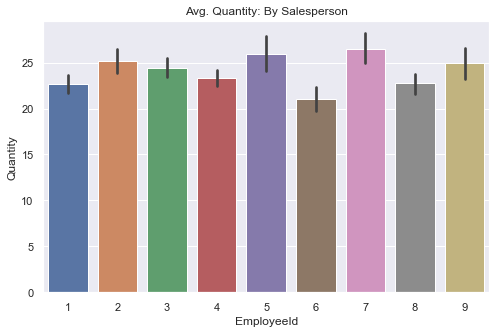

In [97]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=df5, x='EmployeeId', y='Quantity', ci=68, ax=ax)

plt.title('Avg. Quantity: By Salesperson');

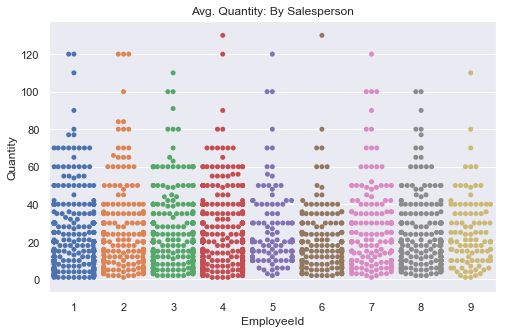

In [98]:
fig, ax = plt.subplots(figsize=(8,5))

sns.swarmplot(data=df5, x='EmployeeId', y='Quantity', ax=ax)

plt.title('Avg. Quantity: By Salesperson');

> There appears to be some differences, albeit slight, for each employee in regards to quanity sold per order. The swarmplot shows what looks to be a fairly even distribution between each of the employees. The error bars in the barplot indicate that these differences may be 'give-or-take' around the same level. 

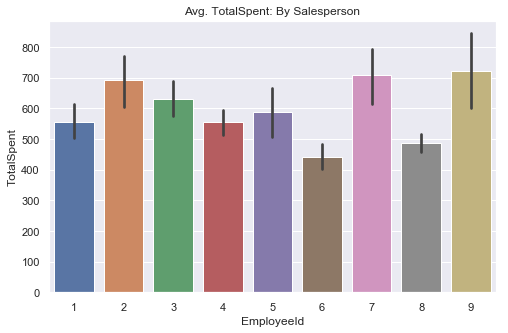

In [99]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=df5, x='EmployeeId', y='TotalSpent', ci=68, ax=ax)

plt.title('Avg. TotalSpent: By Salesperson');

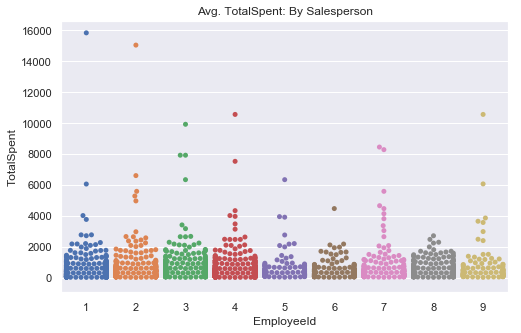

In [100]:
fig, ax = plt.subplots(figsize=(8,5))

sns.swarmplot(data=df5, x='EmployeeId', y='TotalSpent', ax=ax)

plt.title('Avg. TotalSpent: By Salesperson');

> Visually speaking, the TotalSpent category show a lot more variation on the barplot between employees. The swarmplot however, tells a story that appears to indicate not much of a difference between the individual employees. 

In [101]:
quantVSemp = {}
for item in df5['EmployeeId'].unique():
    quantVSemp[item] = df5.groupby('EmployeeId').get_group(item)['Quantity']

In [102]:
for item in sorted(df5['EmployeeId'].unique()):
    print(f'Number of instances in {item}: {len(quantVSemp[item])}')

Number of instances in 1: 345
Number of instances in 2: 241
Number of instances in 3: 321
Number of instances in 4: 420
Number of instances in 5: 117
Number of instances in 6: 168
Number of instances in 7: 176
Number of instances in 8: 260
Number of instances in 9: 107


****************************************************************************

In [103]:
totspentVSemp = {}
for item in df5['EmployeeId'].unique():
    totspentVSemp[item] = df5.groupby('EmployeeId').get_group(item)['TotalSpent']

In [104]:
for item in sorted(df5['EmployeeId'].unique()):
    print(f'Number of instances in {item}: {len(totspentVSemp[item])}')

Number of instances in 1: 345
Number of instances in 2: 241
Number of instances in 3: 321
Number of instances in 4: 420
Number of instances in 5: 117
Number of instances in 6: 168
Number of instances in 7: 176
Number of instances in 8: 260
Number of instances in 9: 107


> Simply put, I will need to use a **One-Way ANOVA** test. This is due to the fact I have *nine* different employees (categories) that I will need to evaluate against each other. 

### Testing Assumptions (One-Way ANOVA)

#### Outliers?

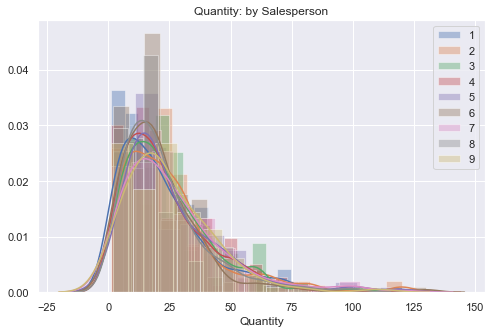

In [105]:
fig, ax = plt.subplots(figsize=(8,5))

for key, val in sorted(quantVSemp.items()):       
    sns.distplot(val, label=key, ax=ax)

plt.title('Quantity: by Salesperson')
ax.legend();

# Check for overall skew of all data

> It appears that this data is fairly normal, I do not expect too many outliers to be pulled from the right tail.

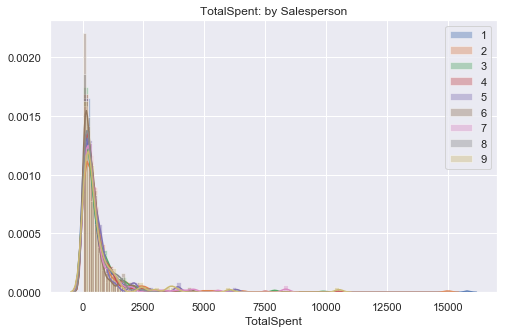

In [106]:
fig, ax = plt.subplots(figsize=(8,5))

for key, val in sorted(totspentVSemp.items()):       
    sns.distplot(val, label=key, ax=ax)

plt.title('TotalSpent: by Salesperson')
ax.legend();

> This set appears to be *way* more skewed than the quantity data. I expect our outlier remove to cut a decent bit off of the right-side tail.

In [107]:
for key, val in sorted(quantVSemp.items()):
    out_dict = fn.find_outliers_Z(val)
    print(f'There are {out_dict.sum()} Z-outliers (quantity) for employee #{key}.')
    
    #out_dict = fn.find_outliers_IQR(val)
    #print(f'There are {out_dict.sum()} {key} IQR-outliers.')

There are 4 Z-outliers (quantity) for employee #1.
There are 4 Z-outliers (quantity) for employee #2.
There are 7 Z-outliers (quantity) for employee #3.
There are 5 Z-outliers (quantity) for employee #4.
There are 3 Z-outliers (quantity) for employee #5.
There are 2 Z-outliers (quantity) for employee #6.
There are 5 Z-outliers (quantity) for employee #7.
There are 6 Z-outliers (quantity) for employee #8.
There are 2 Z-outliers (quantity) for employee #9.


In [108]:
for key, val in sorted(totspentVSemp.items()):
    out_dict = fn.find_outliers_Z(val)
    print(f'There are {out_dict.sum()} Z-outliers (total spent) for employee #{key}.')
    
    #out_dict = fn.find_outliers_IQR(val)
    #print(f'There are {out_dict.sum()} {key} IQR-outliers.')

There are 4 Z-outliers (total spent) for employee #1.
There are 5 Z-outliers (total spent) for employee #2.
There are 4 Z-outliers (total spent) for employee #3.
There are 7 Z-outliers (total spent) for employee #4.
There are 3 Z-outliers (total spent) for employee #5.
There are 3 Z-outliers (total spent) for employee #6.
There are 5 Z-outliers (total spent) for employee #7.
There are 5 Z-outliers (total spent) for employee #8.
There are 2 Z-outliers (total spent) for employee #9.


> I am surprised to see that the TotalSpent data had about the amount of outliers despite what the distplots show of it. Perhaps there are only a few data points dragging it out that far. I am interested to see what the data looks like after removal. 

In [109]:
# Z-score method removal 

for key, val in quantVSemp.items():
    out_dict = fn.find_outliers_Z(val)
    quantVSemp[key] = val[~out_dict]

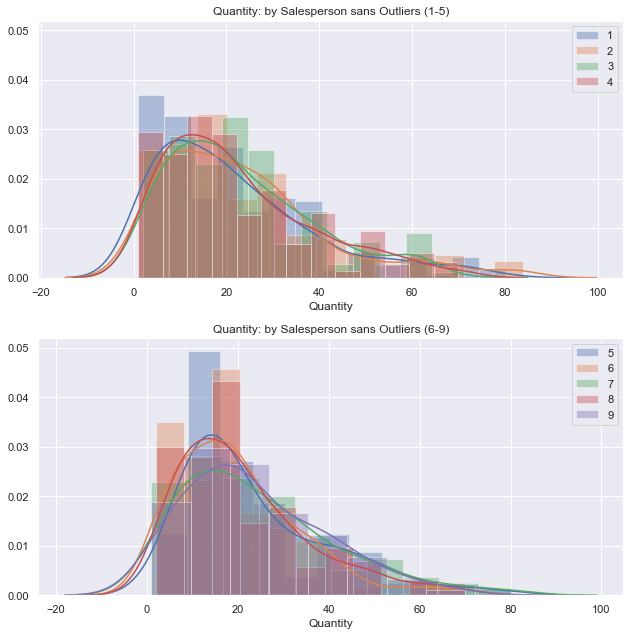

In [140]:
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharey=ax1)

helper2 = [1, 2, 3, 4]

for key, val in sorted(quantVSemp.items()):
    if key in helper2:
        sns.distplot(val, label=key, ax=ax1).set_title('Quantity: by Salesperson sans Outliers (1-5)')
    else:
        sns.distplot(val, label=key, ax=ax2).set_title('Quantity: by Salesperson sans Outliers (6-9)')
        
ax1.legend()
ax2.legend();
        
plt.tight_layout()

> Looking at these graphs, it appears that employees 5, 6, and 8 have a higher percentage of their orders being quantities less than 20. Otherwise both groups seem to be about the same.

In [111]:
for key, val in totspentVSemp.items():
    out_dict = fn.find_outliers_Z(val)
    totspentVSemp[key] = val[~out_dict]

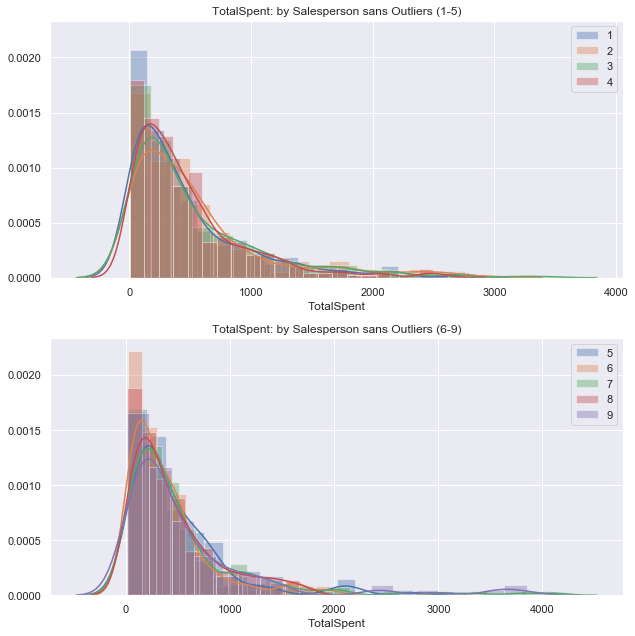

In [139]:
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharey=ax1)

helper2 = [1, 2, 3, 4]

for key, val in sorted(totspentVSemp.items()):
    if key in helper2:
        sns.distplot(val, label=key, ax=ax1).set_title('TotalSpent: by Salesperson sans Outliers (1-5)')
    else:
        sns.distplot(val, label=key, ax=ax2).set_title('TotalSpent: by Salesperson sans Outliers (6-9)')
        
ax1.legend()
ax2.legend();
        
plt.tight_layout()

> Visually, these two groups appear to be quite similar. The second group just has a bit longer of a right-tail due to a few instances.

In [113]:
tst5a = []

for key, val in quantVSemp.items():
    for item in val:
        tst5a.append((key, item))

In [114]:
q5a_fin = pd.DataFrame.from_records(data=tst5a, columns=['EmployeeId', 'Quantity'])
q5a_fin.head()

,EmployeeId,Quantity
0,5,12
1,5,10
2,5,5
3,5,15
4,5,21


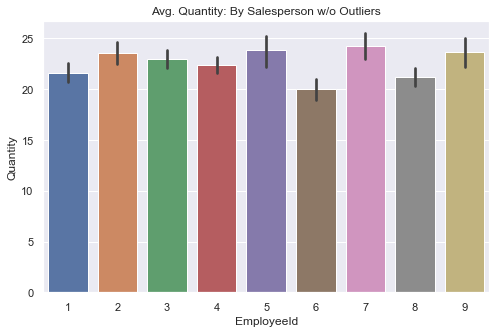

In [115]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=q5a_fin, x='EmployeeId', y='Quantity', ci=68, ax=ax)

plt.title('Avg. Quantity: By Salesperson w/o Outliers');

> Removing outliers has tightened of the variance between the employees on the bar chart, this may not recieve a significant result.

In [116]:
tst5b = []

for key, val in totspentVSemp.items():
    for item in val:
        tst5b.append((key, item))

In [117]:
q5b_fin = pd.DataFrame.from_records(data=tst5b, columns=['EmployeeId', 'TotSpent'])
q5b_fin.head()

,EmployeeId,TotSpent
0,5,168.00
1,5,98.00
2,5,174.00
3,5,45.90
4,5,342.72


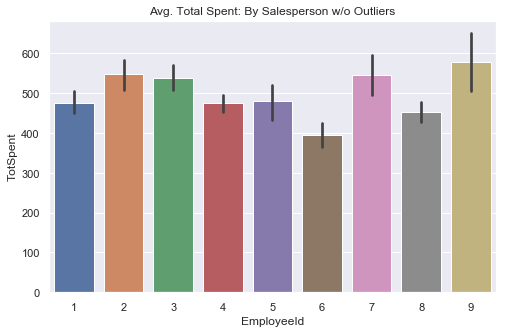

In [118]:
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=q5b_fin, x='EmployeeId', y='TotSpent', ci=68, ax=ax)

plt.title('Avg. Total Spent: By Salesperson w/o Outliers');

> There still appears to be some variance, albeit small among the employees, I do not this visually I can make much of an inference. 

#### Normality?

In [119]:
for key, val in sorted(quantVSemp.items()):
    stat, p = stats.normaltest(val)
        
    print(f'Employee #{key} normal test p-value = {round(p,4)}')
    
    sig = 'is NOT' if p < .05 else 'IS'
    
    print(f'The data {sig} normal.')

Employee #1 normal test p-value = 0.0
The data is NOT normal.
Employee #2 normal test p-value = 0.0
The data is NOT normal.
Employee #3 normal test p-value = 0.0
The data is NOT normal.
Employee #4 normal test p-value = 0.0
The data is NOT normal.
Employee #5 normal test p-value = 0.0
The data is NOT normal.
Employee #6 normal test p-value = 0.0
The data is NOT normal.
Employee #7 normal test p-value = 0.0
The data is NOT normal.
Employee #8 normal test p-value = 0.0
The data is NOT normal.
Employee #9 normal test p-value = 0.0115
The data is NOT normal.


> Although it Employee #9 had a p-value slightly smaller than our alpha, all groups have been determined to be **non-normal**. I will double-check that we have large enough sample sizes to move forward.

In [120]:
for item in sorted(df5['EmployeeId'].unique()):
    print(f'Number of instances in Employee #{item}: {len(quantVSemp[item])}')

Number of instances in Employee #1: 341
Number of instances in Employee #2: 237
Number of instances in Employee #3: 314
Number of instances in Employee #4: 415
Number of instances in Employee #5: 114
Number of instances in Employee #6: 166
Number of instances in Employee #7: 171
Number of instances in Employee #8: 254
Number of instances in Employee #9: 105


In [121]:
for key, val in sorted(totspentVSemp.items()):
    stat, p = stats.normaltest(val)
        
    print(f'Employee #{key} normal test p-value = {round(p,4)}')
    
    sig = 'is NOT' if p < .05 else 'IS'
    
    print(f'The data {sig} normal.')

Employee #1 normal test p-value = 0.0
The data is NOT normal.
Employee #2 normal test p-value = 0.0
The data is NOT normal.
Employee #3 normal test p-value = 0.0
The data is NOT normal.
Employee #4 normal test p-value = 0.0
The data is NOT normal.
Employee #5 normal test p-value = 0.0
The data is NOT normal.
Employee #6 normal test p-value = 0.0
The data is NOT normal.
Employee #7 normal test p-value = 0.0
The data is NOT normal.
Employee #8 normal test p-value = 0.0
The data is NOT normal.
Employee #9 normal test p-value = 0.0
The data is NOT normal.


> All of the groups are **non-normal**. I need to check the sample size.

In [122]:
for item in sorted(df5['EmployeeId'].unique()):
    print(f'Number of instances in Employee #{item}: {len(totspentVSemp[item])}')

Number of instances in Employee #1: 341
Number of instances in Employee #2: 236
Number of instances in Employee #3: 317
Number of instances in Employee #4: 413
Number of instances in Employee #5: 114
Number of instances in Employee #6: 165
Number of instances in Employee #7: 171
Number of instances in Employee #8: 255
Number of instances in Employee #9: 105


> Both the Quantity and TotalSpent data have enough in the groups to ignore the assumption of normality for our ANOVA.

#### Equal Variance?

In [123]:
norm_list5 = []

for key, val in sorted(quantVSemp.items()):
    norm_list5.append(val)

In [124]:
stat, p = stats.levene(*norm_list5)

print(f'Levene test p-value = {round(p,4)}')

sig = 'does NOT' if p < .05 else 'DOES'

print(f'The data {sig} have equal variance.')

Levene test p-value = 0.0939
The data DOES have equal variance.


****************************************************************************

In [125]:
norm_list6 = []

for key, val in sorted(totspentVSemp.items()):
    norm_list6.append(val)

In [126]:
stat, p = stats.levene(*norm_list6)

print(f'Levene test p-value = {round(p,4)}')

sig = 'does NOT' if p < .05 else 'DOES'

print(f'The data {sig} have equal variance.')

Levene test p-value = 0.0143
The data does NOT have equal variance.


> Surprisingly, the data subsets concerning quantity does have equal variance while the other does not. I will *need* to do a Tukey's test on the total spent due to it failing the Levene's test.

### Hypothesis Test

In [127]:
stat, p = stats.f_oneway(*norm_list5)

print(f"One-Way ANOVA p-value = {round(p,4)}")

sig = 'IS' if p < .05 else 'is NOT'

print(f'The data {sig} from different populations.')

One-Way ANOVA p-value = 0.1783
The data is NOT from different populations.


> The One-Way ANOVA indicates that I have **failed to reject the Null Hypothesis ($H_0$)**. There is not enough evidence to say that any given employee has an effect upon the quantity sold in an order.

In [138]:
stat, p = stats.kruskal(*norm_list6)

print(f"Kruskal's p-value = {round(p,4)}")

sig = 'IS' if p < .05 else 'is NOT'

print(f'The data {sig} from different populations.')

Kruskal's p-value = 0.2974
The data is NOT from different populations.


In [128]:
stat, p = stats.f_oneway(*norm_list6)

print(f"One-Way ANOVA p-value = {round(p,4)}")

sig = 'IS' if p < .05 else 'is NOT'

print(f'The data {sig} from different populations.')

One-Way ANOVA p-value = 0.0262
The data IS from different populations.


> In the case of the total amount spent on an order, the One-Way ANOVA allows me to **reject the Null Hypothesis ($H_0$)**. The data does in fact suggest a statistical difference between employees when is comes to the total bill.

### Post-Hoc Calculations

In [129]:
model5a = pairwise_tukeyhsd(df5['Quantity'], df5['EmployeeId'])
model5a.summary()

group1,group2,meandiff,lower,upper,reject
1,2,2.481,-2.4718,7.4338,False
1,3,1.8176,-2.7574,6.3926,False
1,4,0.6851,-3.6015,4.9717,False
1,5,3.3052,-3.0063,9.6168,False
1,6,-1.6494,-7.1997,3.9008,False
1,7,3.7997,-1.6651,9.2645,False
1,8,0.0988,-4.7462,4.9439,False
1,9,2.3098,-4.2183,8.8379,False
2,3,-0.6634,-5.6918,4.3649,False
2,4,-1.7959,-6.5634,2.9715,False


> There are no groups that show significantly different.

In [130]:
df_tukey5a = fn.prep_data_for_tukeys(quantVSemp)

In [131]:
df_tukey5a.head()

,data,group
0,12.0,5
1,10.0,5
2,5.0,5
17,15.0,5
18,21.0,5


In [132]:
model5a_2 = pairwise_tukeyhsd(df_tukey5a['data'], df_tukey5a['group'])
model5a_2.summary()

group1,group2,meandiff,lower,upper,reject
1,2,1.9888,-2.223,6.2006,False
1,3,1.3462,-2.549,5.2414,False
1,4,0.7861,-2.854,4.4261,False
1,5,2.2058,-3.1822,7.5938,False
1,6,-1.6368,-6.3502,3.0765,False
1,7,2.6151,-2.0516,7.2819,False
1,8,-0.414,-4.5418,3.7137,False
1,9,2.0003,-3.5581,7.5587,False
2,3,-0.6426,-4.928,3.6428,False
2,4,-1.2028,-5.2577,2.8521,False


**************************************************************************

In [133]:
model5b = pairwise_tukeyhsd(df5['TotalSpent'], df5['EmployeeId'])
model5b.summary()

group1,group2,meandiff,lower,upper,reject
1,2,134.1944,-117.9953,386.3841,False
1,3,74.9821,-157.9727,307.9368,False
1,4,-2.3316,-220.6011,215.9379,False
1,5,31.1346,-290.2426,352.5118,False
1,6,-116.8745,-399.4868,165.7378,False
1,7,150.9404,-127.3188,429.1996,False
1,8,-68.9018,-315.6068,177.8032,False
1,9,165.6717,-166.7309,498.0742,False
2,3,-59.2123,-315.2499,196.8252,False
2,4,-136.526,-379.2787,106.2267,False


> Despite getting a significant result with the One-Way ANOVA, the Tukey's test was unable to detect any significance between any groups within the dataset.

In [134]:
df_tukey5b = fn.prep_data_for_tukeys(totspentVSemp)

In [135]:
df_tukey5b.head()

,data,group
0,168.00,5
1,98.00,5
2,174.00,5
17,45.90,5
18,342.72,5


In [136]:
model5b_2 = pairwise_tukeyhsd(df_tukey5b['data'], df_tukey5b['group'])
model5b_2.summary()

group1,group2,meandiff,lower,upper,reject
1,2,70.6795,-67.9146,209.2736,False
1,3,62.1979,-65.5036,189.8995,False
1,4,-2.0207,-121.7839,117.7426,False
1,5,2.7041,-174.3746,179.7827,False
1,6,-81.4678,-236.6872,73.7517,False
1,7,68.5247,-84.8486,221.8981,False
1,8,-24.7293,-160.2376,110.779,False
1,9,101.7408,-80.9369,284.4186,False
2,3,-8.4815,-149.2052,132.2421,False
2,4,-72.7002,-206.2617,60.8614,False


### Q5 Summary

> The first part of my hypothesis, although promising, failed to produce significant results. Alone this result shows that currently all of the sales team is moving a consistent amount of product and on average *do not* out perform one another. 

> The second part has yielded interesting results. This leads me to believe that I potentially got a Type I Error for the Total Spent data. I would need more data and/or run more models to verify my results.

**Recommendations:** Given my results, I am unable to make a clear recommendation about their salesforce. I can say that the data does indicate the possibility of an individual sales person effecting the total amount spent in any given order.

## Results

**Hypothesis Summary**

* **Q1**: *Rejected $H_0$*. Discount levels of 5%, 15%, 20%, and 25% were shown to have an effect on the average quantity.

* **Q2**: *Failed to reject $H_0$*. There was not enough evidence to suggest discounting has an effect on the total amount spent on an order. This is also true amongst each of the discount levels.

* **Q3**: *Failed to reject $H_0$*. The data was unable to demonstrate that the region a product was sold in has an effect on the quantity of product in an order. This is also true between each of the regions.

* **Q4**: *Rejected $H_0$*. The data indicated that products they waited until sold out to reorder and/or when 15 units were left showed a difference in the total amount spent on orders they were included in.

* **Q5**:
    * **Quantity**: *Failed to reject $H_0$*. The statistical test was unable to confirm that the employee involved in a given sale has any significant effect on the amount of product purchased.
    * **Total Spent**: *Rejected $H_0$*. Our One-Way ANOVA test allowed us to reject the null, while our Tukey's test could not show a specific group to be significantly different than another.

**Recommendations:**

- **Q1:** Given this information, I would suggest that they have no reason to give discounts larger than 5%, as it effects the quantity purchased just the same as any of the higher options.

- **Q2:**  Now, with the knowledge that discounting has a significant effect on the quantity purchased *and* the total amount spent, I would recommend that they either stop offering higher (>5%) discounts in general **OR** do not give more than 15%, as my results show that this is the next level at which there is not *significant* difference.

- **Q3:** Knowing that no specific region out purchases another, I would recommend that this company consolidate their shipping costs as much as possbile. Looking into an option that will provide them the widest reach for the least amount of money will prove useful.

- **Q4:** I would suggest setting a reorder level of 0 *or* 15 for items, given that my finding would indicate a higher amount spent on items within these categories. However, these findings may be due to influence from other variables, given more time I would like to dig deeper here.

- **Q5:**  Given my results, I am unable to make a clear recommendation about their salesforce. I can say that the data does indicate the possibility of an individual sales person effecting the total amount spent in any given order.